## Set Up Dependencies

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from slugify import slugify
from teeplot import teeplot as tp


## Fetch and Preprocess Data

In [2]:
df = pd.read_parquet("https://osf.io/wa32b/download")


In [3]:
df = df.rename(
    columns={
        "annotation_size_bits": "Annotation Size (bits)",
        "algorithm": "Algorithm",
        "population_size": "Population Size",
        "num_generations": "Num Generations",
        "num_islands": "Num Islands",
        "num_niches": "Num Niches",
        "tournament_size": "Tournament Size",
        "replicate": "Replicate",
        "downsample": "Downsample",
        "differentia_width_bits": "Differentia Width (bits)",
    },
)


In [4]:
df["Dynamics"] = (
    "islands"
    + df["Num Islands"].astype(str)
    + "-niches"
    + df["Num Niches"].astype(str)
    + "-tsize"
    + df["Tournament Size"].astype(str)
)


In [5]:
df["Scenario"] = df["Dynamics"].map(
    {
        "islands1-niches1-tsize2": "plain",
        "islands1-niches1-tsize1": "drift",
        "islands4-niches2-tsize2": "mild structure",
        "islands64-niches8-tsize2": "rich structure",
    }
)


In [6]:
df["algo"] = df["Algorithm"].map(
    {
        "surf-steady": "\nsurf\nsteady",
        "col-steady": "\ncol\nsteady",
        "surf-hybrid": "\nsurf\nhybrid",
        "surf-tilted": "\nsurf\ntilted",
        "col-tilted": "\ncol\ntilted",
    },
)


In [7]:
df["Scale"] = (
    "npop"
    + df["Population Size"].astype(str)
    + "-ngen"
    + df["Num Generations"].astype(str)
)


In [8]:
row_order = [
    # "surf-steady",
    # "col-steady",
    # "surf-hybrid",
    # "surf-tilted",
    # "col-tilted",
    # "surf\nsteady",
    "\ncol\nsteady",
    "\nsurf\nhybrid",
    "\nsurf\ntilted",
    # "col\ntilted",
]


def joyhist(*args, **kwargs):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    g = sns.displot(
        *args,
        **kwargs,
        kind="hist",
        row_order=row_order,
        hue_order=["true", "reconstructed"],
        multiple="fill",
        common_norm=False,
        aspect=3,
        height=1.1,
        log_scale=(True, False),
        bins=20,
        element="step",
        palette=["none", "#1f77b4"],
        facet_kws=dict(margin_titles=True, sharex="col"),
        legend=False,
    )
    g.refline(y=0.5, linestyle="--", linewidth=2, color="black")
    g.refline(y=0.0, linestyle="-", linewidth=3, color="black")
    g.set(ylim=(0, 0.7))

    g.figure.subplots_adjust(hspace=0.05)

    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    g.set_titles(col_template="{col_name}", row_template="{row_name}")

    for r, arr in enumerate(g.axes):
        for c, ax in enumerate(arr):
            color = plt.get_cmap("tab10_r")(r)
            for patch in ax.get_children():
                try:
                    if isinstance(patch, mpl.collections.PolyCollection):
                        patch.set_facecolor(color)
                        patch.set_alpha(0.5)
                        patch.set_clip_on(False)
                        break
                except AttributeError:
                    pass

            # adapted from https://cduvallet.github.io/posts/2018/11/facetgrid-ylabel-access
            # Rotate facet labels
            if ax.texts:
                # This contains the right ylabel text
                txt = ax.texts[0]
                ax.text(
                    txt.get_unitless_position()[0],
                    txt.get_unitless_position()[1],
                    txt.get_text(),
                    transform=ax.transAxes,
                    va="center",
                    # fontsize="large",
                )
                # Remove the original text
                ax.texts[0].remove()
    return g


teeplots/annotation-size=32+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop4096-ngen10000+viz=joyhist+x=time-ago+ext=.pdf


teeplots/annotation-size=32+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop4096-ngen10000+viz=joyhist+x=time-ago+ext=.png


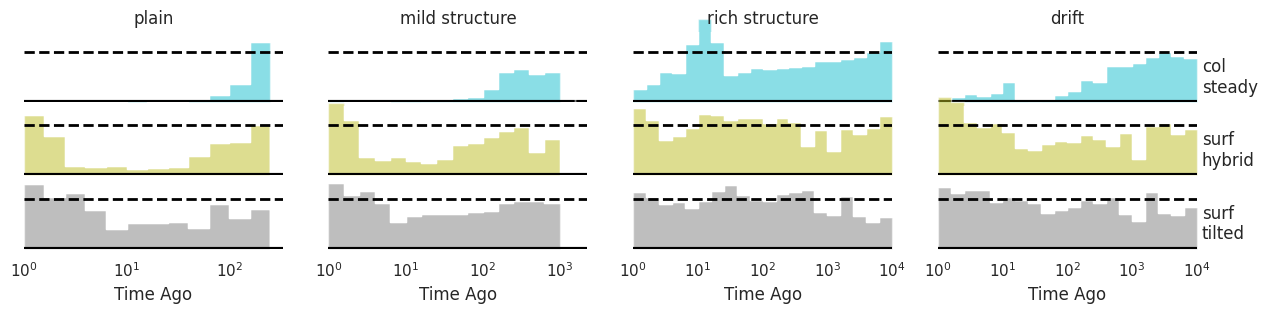

teeplots/annotation-size=64+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop4096-ngen10000+viz=joyhist+x=time-ago+ext=.pdf


teeplots/annotation-size=64+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop4096-ngen10000+viz=joyhist+x=time-ago+ext=.png


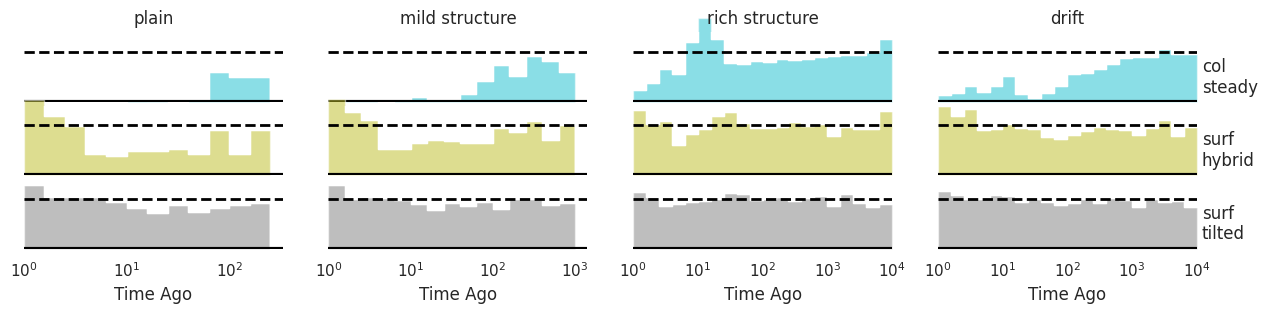

teeplots/annotation-size=256+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop4096-ngen10000+viz=joyhist+x=time-ago+ext=.pdf


teeplots/annotation-size=256+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop4096-ngen10000+viz=joyhist+x=time-ago+ext=.png


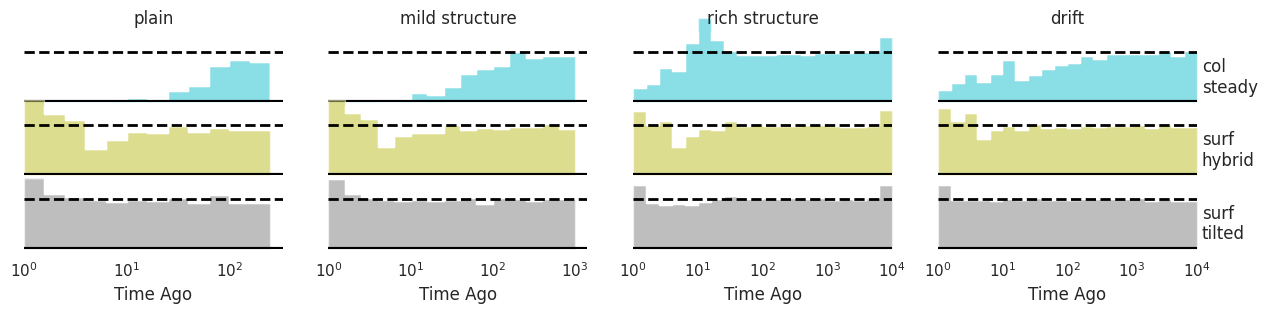

teeplots/annotation-size=256+col=scenario+differentia-width=8+hue=kind+row=algo+scale=npop4096-ngen10000+viz=joyhist+x=time-ago+ext=.pdf


teeplots/annotation-size=256+col=scenario+differentia-width=8+hue=kind+row=algo+scale=npop4096-ngen10000+viz=joyhist+x=time-ago+ext=.png


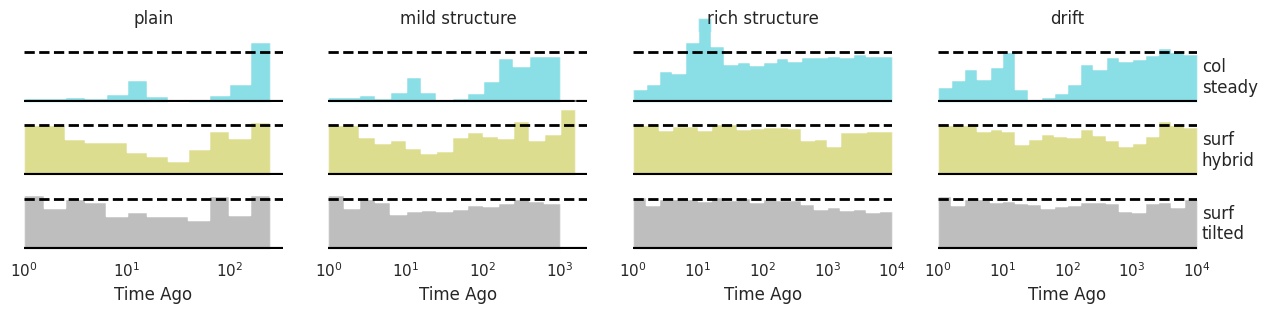

teeplots/annotation-size=32+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop4096-ngen100000+viz=joyhist+x=time-ago+ext=.pdf


teeplots/annotation-size=32+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop4096-ngen100000+viz=joyhist+x=time-ago+ext=.png


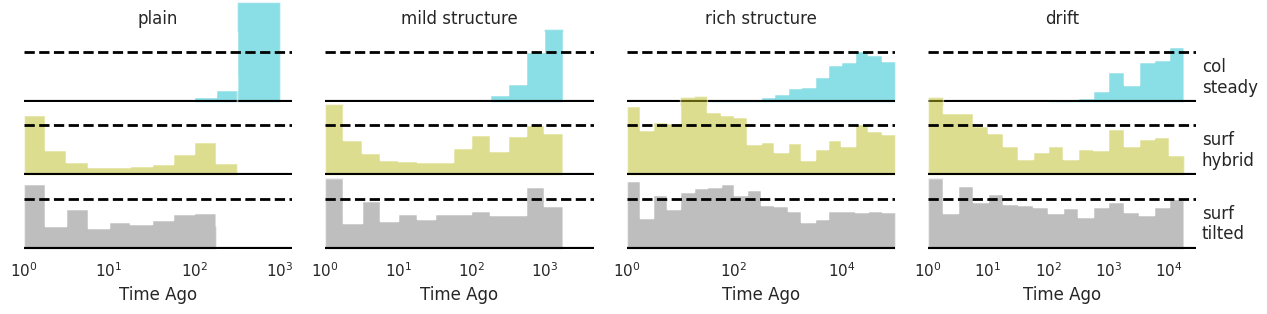

teeplots/annotation-size=64+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop4096-ngen100000+viz=joyhist+x=time-ago+ext=.pdf


teeplots/annotation-size=64+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop4096-ngen100000+viz=joyhist+x=time-ago+ext=.png


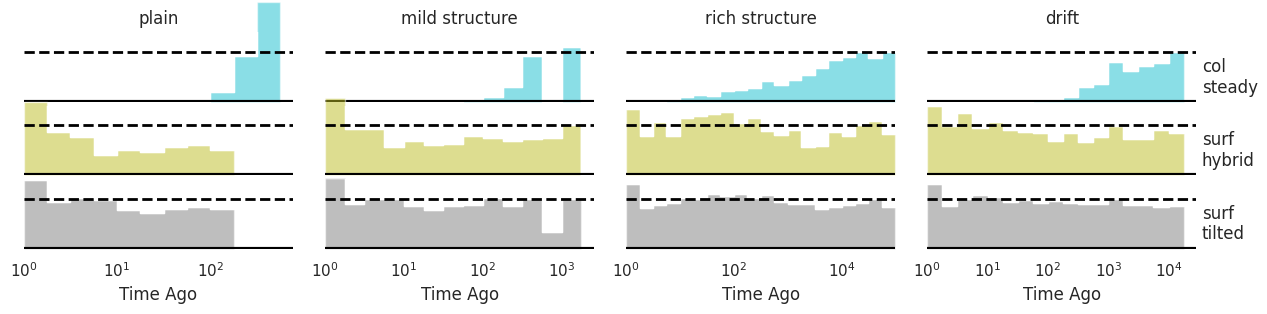

teeplots/annotation-size=256+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop4096-ngen100000+viz=joyhist+x=time-ago+ext=.pdf


teeplots/annotation-size=256+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop4096-ngen100000+viz=joyhist+x=time-ago+ext=.png


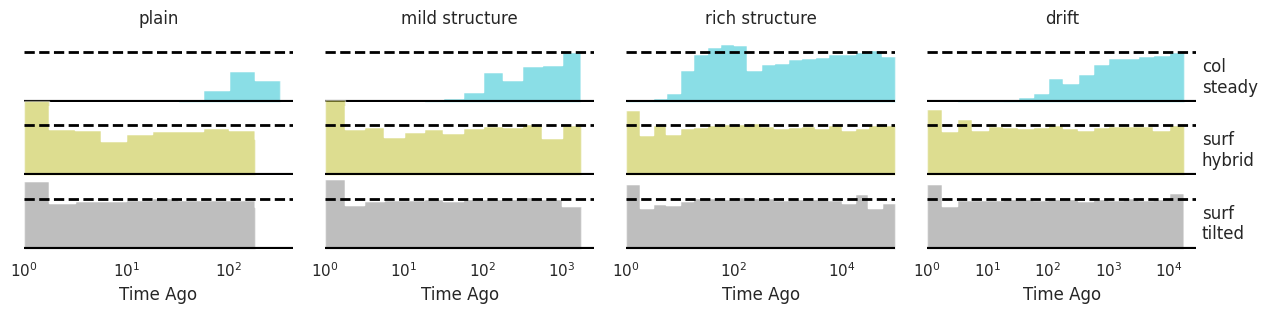

teeplots/annotation-size=256+col=scenario+differentia-width=8+hue=kind+row=algo+scale=npop4096-ngen100000+viz=joyhist+x=time-ago+ext=.pdf


teeplots/annotation-size=256+col=scenario+differentia-width=8+hue=kind+row=algo+scale=npop4096-ngen100000+viz=joyhist+x=time-ago+ext=.png


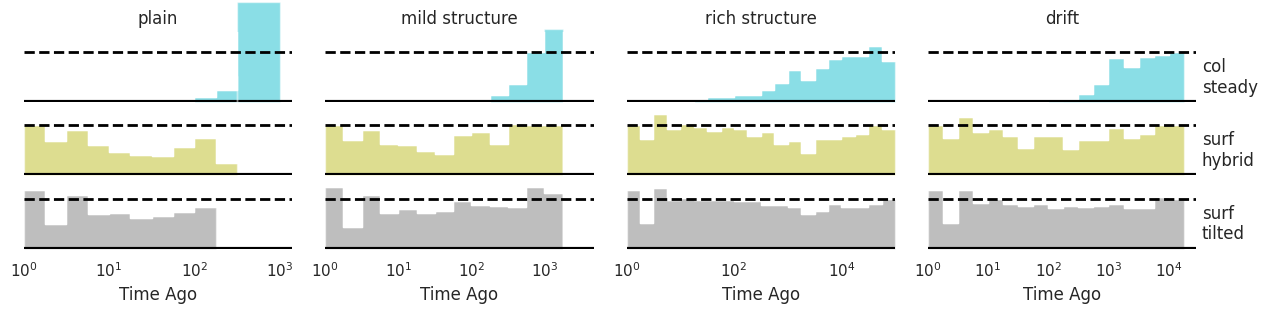

teeplots/annotation-size=32+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop65536-ngen10000+viz=joyhist+x=time-ago+ext=.pdf


teeplots/annotation-size=32+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop65536-ngen10000+viz=joyhist+x=time-ago+ext=.png


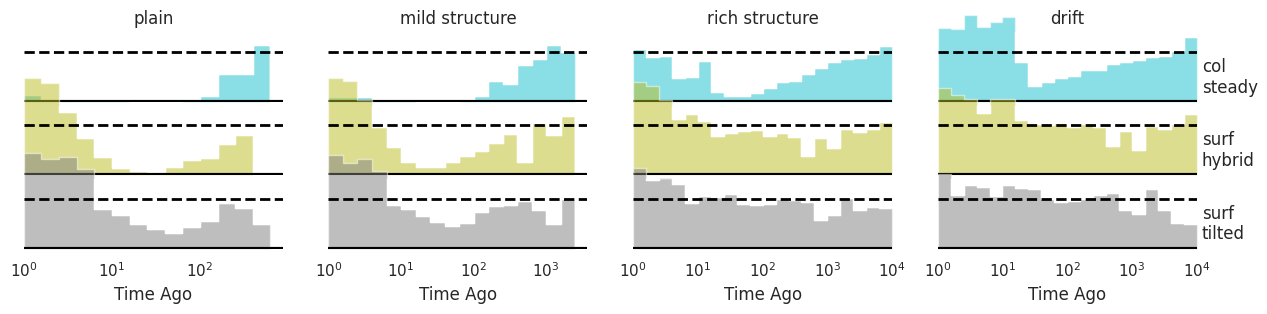

teeplots/annotation-size=64+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop65536-ngen10000+viz=joyhist+x=time-ago+ext=.pdf


teeplots/annotation-size=64+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop65536-ngen10000+viz=joyhist+x=time-ago+ext=.png


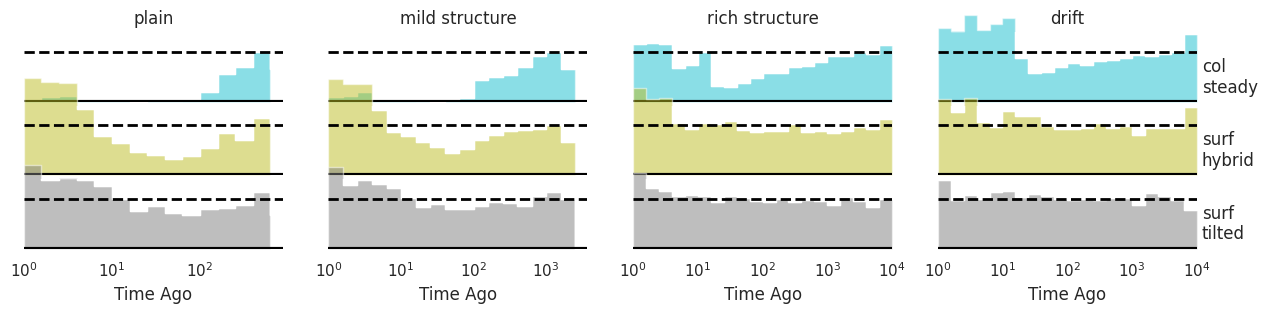

teeplots/annotation-size=256+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop65536-ngen10000+viz=joyhist+x=time-ago+ext=.pdf


teeplots/annotation-size=256+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop65536-ngen10000+viz=joyhist+x=time-ago+ext=.png


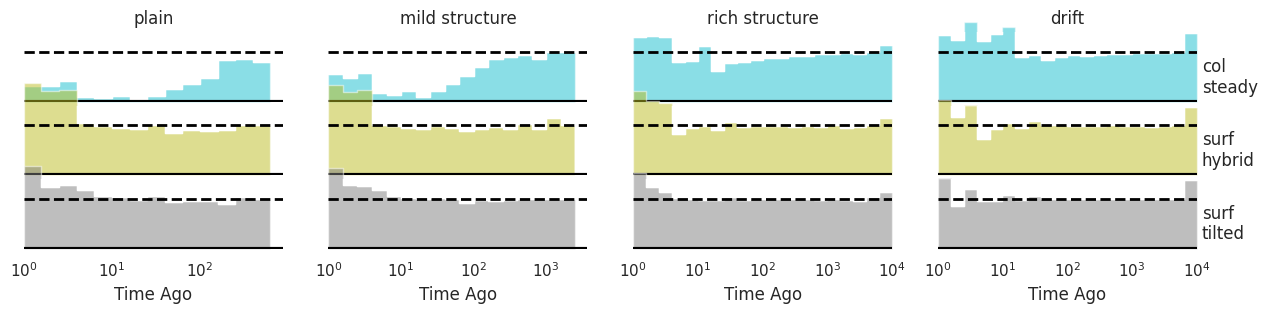

teeplots/annotation-size=256+col=scenario+differentia-width=8+hue=kind+row=algo+scale=npop65536-ngen10000+viz=joyhist+x=time-ago+ext=.pdf


teeplots/annotation-size=256+col=scenario+differentia-width=8+hue=kind+row=algo+scale=npop65536-ngen10000+viz=joyhist+x=time-ago+ext=.png


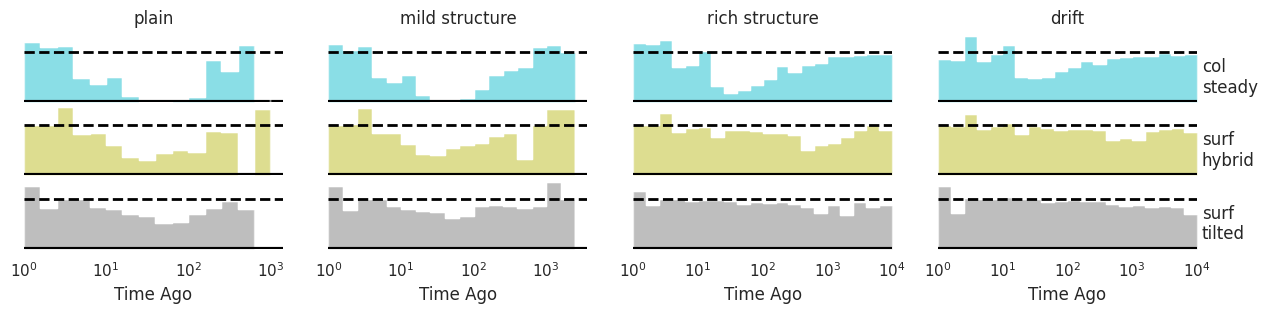

teeplots/annotation-size=32+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop65536-ngen100000+viz=joyhist+x=time-ago+ext=.pdf


teeplots/annotation-size=32+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop65536-ngen100000+viz=joyhist+x=time-ago+ext=.png


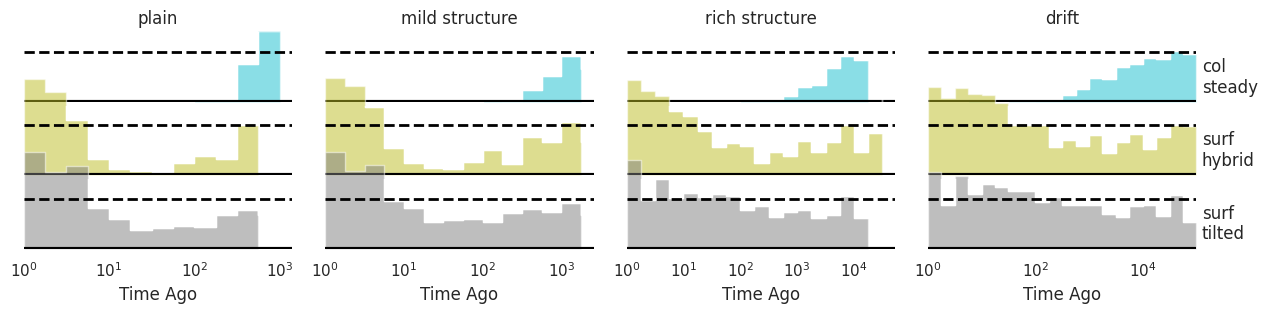

teeplots/annotation-size=64+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop65536-ngen100000+viz=joyhist+x=time-ago+ext=.pdf


teeplots/annotation-size=64+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop65536-ngen100000+viz=joyhist+x=time-ago+ext=.png


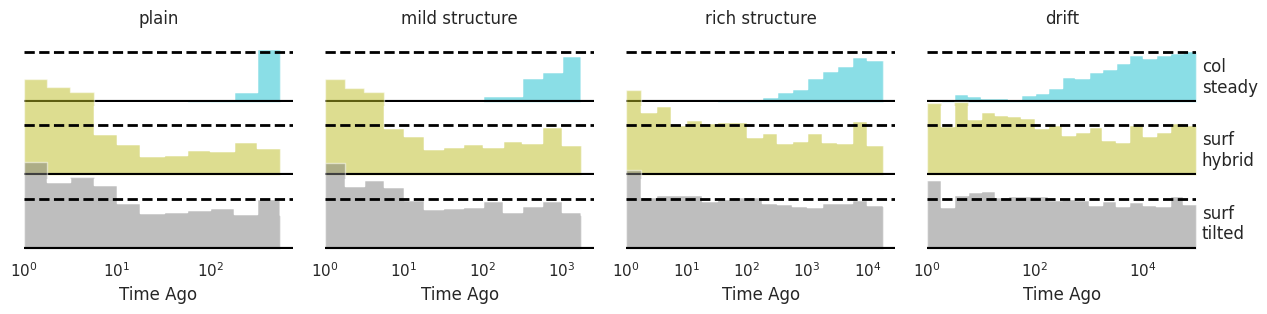

teeplots/annotation-size=256+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop65536-ngen100000+viz=joyhist+x=time-ago+ext=.pdf


teeplots/annotation-size=256+col=scenario+differentia-width=1+hue=kind+row=algo+scale=npop65536-ngen100000+viz=joyhist+x=time-ago+ext=.png


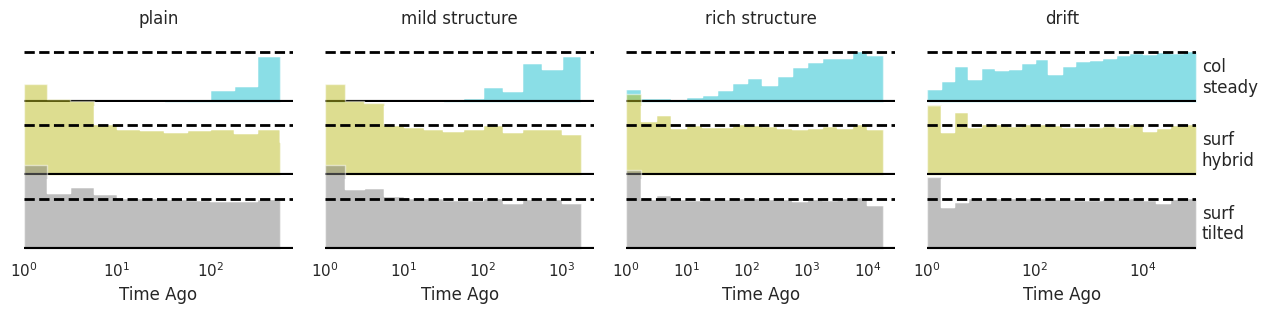

teeplots/annotation-size=256+col=scenario+differentia-width=8+hue=kind+row=algo+scale=npop65536-ngen100000+viz=joyhist+x=time-ago+ext=.pdf


teeplots/annotation-size=256+col=scenario+differentia-width=8+hue=kind+row=algo+scale=npop65536-ngen100000+viz=joyhist+x=time-ago+ext=.png


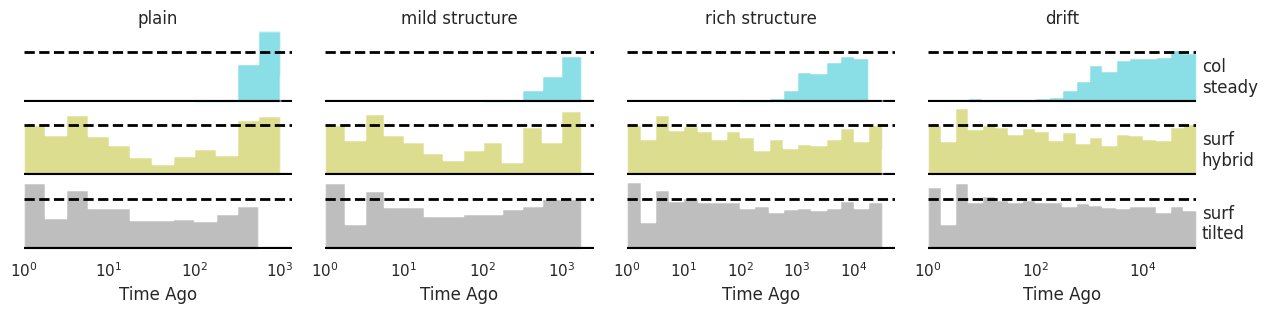

In [9]:
groupby = ["Scale", "Annotation Size (bits)", "Differentia Width (bits)"]
for what, group in df[df["Downsample"] == 500].groupby(groupby):
    group["Time Ago"] = group["origin_time"].max() + 1 - group["origin_time"]
    tp.tee(
        joyhist,
        data=group,
        x="Time Ago",
        row="algo",
        col="Scenario",
        col_order=[
            "plain",
            "mild structure",
            "rich structure",
            "drift",
        ],
        hue="kind",
        teeplot_outattrs=dict(
            zip(
                (slugify(g.replace(" (bits)", "")) for g in groupby),
                map(str, what),
            ),
        ),
    )


## Reproducibility

In [10]:
import datetime
datetime.datetime.now().isoformat()

'2024-12-06T17:14:28.298910'

In [11]:
%load_ext watermark
%watermark

Last updated: 2024-12-06T17:14:28.311704+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.22.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1025-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit



In [12]:
!pip freeze

alifedata-phyloinformatics-convert==0.16.2
annotated-types==0.6.0
anytree==2.12.1
appdirs==1.4.4
argcomplete==3.5.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
asttokens==2.4.1
attrs==23.2.0
Automat==20.2.0
Babel==2.8.0
backstrip==0.2.4
bcrypt==3.2.0
beautifulsoup4==4.12.3
biopython==1.83
bitarray==2.9.2
bitstring==4.1.4
black==22.10.0
bleach==6.1.0
blinker==1.4
Brotli==1.1.0
CacheControl==0.12.10
certifi==2024.2.2
cffi==1.16.0
chardet==4.0.0
charset-normalizer==3.3.2
click==8.1.7
cliffs-delta==1.0.0
cloud-init==24.3.1
colorama==0.4.4
colorclade==0.2.0
comm==0.2.1
command-not-found==0.3
configobj==5.0.6
constantly==15.1.0
contourpy==1.2.0
cryptography==3.4.8
cssselect==1.1.0
cssselect2==0.7.0
cycler==0.12.1
dataclasses==0.6
dbus-python==1.2.18
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
DendroPy==4.6.1
Deprecated==1.2.14
distro==1.7.0
distro-info==1.1+ubuntu0.2
distutils-strtobool==0.1.0
entrypoints==0.4
ete3==3.1.3
exceptiongroup==1.2.0
executing==2.0.1
fastjsonschema==2.19